In [1]:
import numpy as np

### Weight initializers

In [2]:
class RandomInitializer():
    def initialize(self, shape):
        W = np.random.randn(shape[0], shape[1])
        return W

class ZerosInitializer():
    def initialize(self, shape):
        W = np.zeros(shape)
        return W

class HeInitializer():
    def initialize(self, shape):
        W = np.random.randn(shape[0], shape[1]) * np.sqrt(2 / shape[1])
        return W


## Activation funcs

In [3]:
class RELU():
    def activate(self, Z):
        return Z * (Z > 0)

    def derivative(self, Z):
        return 1 * (Z > 0)


class Sigmoid():
    def activate(self, Z):
        return 1 / (1 + np.exp(-Z))

    def derivative(self, Z):
        return self.activate(Z) * (1 - self.activate(Z))


class Linear():
    def activate(self, Z):
        return Z

    def derivative(self, Z):
        return (np.ones(Z.shape))



## Costs

In [4]:
class BinaryCrossEntropy():
    def compute_cost(self, y_pred, y_true):
        #shape y_pred and y_true = (1, m_examples)
        m = y_true.shape[1]

        #lets cut off a  tiny constant to avoid log0 problem
        epsilon = 10 ** -15
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)

        cost =  -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

        cost = np.sum(cost, axis=1, keepdims=True) * (1 / m)

        return (cost)

    def derivative(self, y_pred, y_true):

        #Do it to avoid division by 0
        epsilon = 10 ** -15
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)

        dA = - (y_true / y_pred) + (1 - y_true) / (1 - y_pred)

        return (dA)

## Layers

In [5]:
class Layer():
    def __init__(self, n_units, activation, l2_reg=0, weight_initializer=HeInitializer):
        self.activation = activation
        self.n_units = n_units
        self.l2_reg =l2_reg

        self.activation = activation()

        #initialize cache
        self.Z = None
        self.A = None

        #initialize params
        #waiting for initializing the model
        self.initializer = weight_initializer
        self.W = None
        self.b = ZerosInitializer().initialize((n_units, 1))

        #We will need them for Adam and Momentum
        #moments
        self.V_dW = None
        self.V_db = ZerosInitializer().initialize((n_units, 1))
        #RMS_prop part
        self.S_dw = None
        self.S_db = ZerosInitializer().initialize((n_units, 1))


        #grads
        self.dZ = None
        self.dA = None

        self.dW = None
        self.db = None

    def initialize(self, n_units_prev):
        shape = (self.n_units, n_units_prev)
        self.W = self.initializer().initialize(shape)

        #initialize params in case we use Adam/Momentum
        self.V_dW = ZerosInitializer().initialize(shape)
        self.S_dW = ZerosInitializer().initialize(shape)


    def forward_propogation(self, A_prev):
        #keep A_prev for backprop
        self.A_prev = A_prev

        self.Z = np.dot(self.W, A_prev) + self.b
        self.A = self.activation.activate(self.Z)

        return (self.A)

    def back_propogation(self, W_next=None, dZ_next=None, dA_final=None):

        batch_size = self.Z.shape[1]

        #Check for valid input
        if dA_final is None:
            if W_next is None or dZ_next is None:
                raise ValueError("Either both W_next and dZ_next must be provided, or dA_final must be provided.")


        #compute and keep gradients
        #dA_final is a specific case, where our layer is final and we compute cost derivs
        if dA_final is not None:
            self.dA = dA_final
        else:
            self.dA = np.dot(W_next.T, dZ_next)

        self.dZ = self.dA * self.activation.derivative(self.Z)

        #regularization
        l2_term = (self.l2_reg / batch_size) * self.W

        self.dW = np.dot(self.dZ, self.A_prev.T) * (1 / batch_size) + l2_term
        self.db = np.sum(self.dZ, axis=1, keepdims=True) * (1 / batch_size)


## Optimizers

In [91]:
class GradientDescent():
    def __init__(self, learning_rate):
        self.counter = 1
        self.learning_rate = learning_rate

    def update(self, layer):
        #update params of layer
        layer.W = layer.W - self.learning_rate * layer.dW
        layer.b = layer.b - self.learning_rate * layer.db

    def tick(self):
        self.counter += 1


class Momentum():
    def __init__(self, learning_rate, beta=0.9, bias_correction=False):

        self.counter = 1
        self.learning_rate = learning_rate
        self.beta = beta

        self.bias_correction = bias_correction
        self.epsilon = 10 ** -8

    def update(self, layer):

        #compute new velocities
        layer.V_dW = self.beta * layer.V_dW + (1 - self.beta) * layer.dW
        layer.V_db = self.beta * layer.V_db + (1 - self.beta) * layer.db

        if self.bias_correction:
            #correct velocities
            layer.V_dW = layer.V_dW / (1 - self.beta ** self.counter)
            layer.V_db = layer.V_db / (1 - self.beta ** self.counter)


        #update params
        layer.W = layer.W - self.learning_rate * layer.V_dW
        layer.b = layer.b - self.learning_rate * layer.V_db

    def tick(self):
        self.counter += 1


class Adam():
    def __init__(self, learning_rate, beta1=0.9, beta2=0.99, bias_correction=False):

        self.counter = 1

        self.learning_rate = learning_rate
        self.beta1 = beta1 #Momentum
        self.beta2 = beta2 #RMSprop

        self.bias_correction = bias_correction

        self.epsilon = 10 ** -8

    def update(self, layer):
        #compute new velocities
        layer.V_dW = self.beta1 * layer.V_dW + (1 - self.beta1) * layer.dW
        layer.V_db = self.beta1 * layer.V_db + (1 - self.beta1) * layer.db

        #compute new second moments
        layer.S_dW = self.beta2 * layer.S_dW + (1 - self.beta2) * np.square(layer.dW)
        layer.S_db = self.beta2 * layer.S_db + (1 - self.beta2) * np.square(layer.db)


        if self.bias_correction:
            #correct velocities
            layer.V_dW = layer.V_dW / (1 - self.beta1 ** self.counter)
            layer.V_db = layer.V_db / (1 - self.beta1 ** self.counter)

            #correct 2nd moments
            layer.S_dW = layer.S_dW / (1 - self.beta2 ** self.counter)
            layer.S_db = layer.S_db / (1 - self.beta2 ** self.counter)

        #UPdate parameters

        layer.W = layer.W - self.learning_rate * (layer.V_dW / (np.sqrt(layer.S_dW) + self.epsilon))
        layer.b = layer.b - self.learning_rate * (layer.V_db / (np.sqrt(layer.S_db) + self.epsilon))

    def tick(self):
        self.counter += 1






## Models


In [77]:
class Model():
  def __init__(self, X, Y,layers):
    #X has shape (n_features, m_examples)
    #Y has shape (1, m_examples)

    self.layers = layers
    self.n_layers = len(layers)
    self.m_examples = X.shape[1]

    self.X = X
    self.Y = Y

    self.minibatches = [] #list of tuples (X_batch, Y_batch)

    self.costfunc = None
    self.optimizer = None

  def _init_weights(self):

    n_unit_prev = self.X.shape[0]

    for layer in self.layers:
      layer.initialize(n_unit_prev)

      #set n_units_prev for next initialization
      n_unit_prev = layer.n_units

  def _make_minibatches(self, batch_size=None):
    if batch_size is None:
      self.minibatches.append((self.X, self.Y))
      return

    complete_batches = self.m_examples // batch_size

    for k in range(0, complete_batches):

        #extracting a particular slice of data
        X_k = self.X[:, k * batch_size : (k + 1) * batch_size]
        Y_k = self.Y[:, k * batch_size : (k + 1) * batch_size]

        minibatch = (X_k, Y_k)
        self.minibatches.append(minibatch)

        #add incomplete batch in case we have remaining examples
    if (self.m_examples % batch_size != 0):
      X_k = self.X[:, complete_batches * batch_size : ]
      Y_k = self.Y[:, complete_batches * batch_size : ]
      minibatch = (X_k, Y_k)
      self.minibatches.append(minibatch)



    #TODO: implement splitting into minibatches here...

  def compile(self, costfunc, optimizer):
    self.costfunc = costfunc
    self.optimizer = optimizer


  def predict(self, X):
    A_prev = X

    for layer in self.layers:
      A = layer.forward_propogation(A_prev)
      A_prev = A

    return A

  def _backprop(self, dA_final):

      L = self.n_layers

      #mannualy set backprop for last layer
      self.layers[L - 1].back_propogation(dA_final=dA_final)

      #loop goes from L - 2 up to 0
      for l in range(L - 2, -1, -1):
        self.layers[l].back_propogation(self.layers[l + 1].W,
                                        self.layers[l + 1].dZ)

  def _update_all_params(self):
    #goes over layers updating params using computed gradients
    for layer in self.layers:
      self.optimizer.update(layer)

    self.optimizer.tick()


  def fit(self, epochs, batch_size=None, n_reports=10):

    #init weights
    self._init_weights()

    #split into minibatches
    self._make_minibatches(batch_size)


    self.history = []
    for epoch in range(0, epochs + 1):

      #compute cost
      all_predictions = self.predict(self.X)
      total_cost = self.costfunc.compute_cost(all_predictions, self.Y)
      self.history.append(float(total_cost))

      if ((epoch) % (epochs // n_reports) == 0):
        print("Epoch #{}, cost = {}".format(epoch, total_cost))


      for batch in self.minibatches:
        X_batch, Y_batch = batch

        batch_predictions = self.predict(X_batch)

        dA_final = self.costfunc.derivative(batch_predictions, Y_batch)

        self._backprop(dA_final)
        self._update_all_params()


**Using our model on real data**

So, let's upload titanic dataset

In [48]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd



***Data Preprocessing***

In [59]:
df = pd.read_csv("titanic_train.csv")

#some data definetly useless for predicion such as ticket number, name
df = df.drop(["Ticket", "PassengerId", "Name", "Cabin"], axis=1)

df["Sex"] = df["Sex"].replace({"male" : 0, "female" : 1})

df["Embarked"] = df["Embarked"].replace({"S" : 0, "C" : 1, "Q": 2})


df["Age"] = df["Age"].fillna(df["Age"].mean())
df.dropna(inplace=True)


X = df.drop("Survived", axis=1).values
y = df["Survived"].values


#Scaling Features

std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

#Splitting into train/test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.75, random_state=1)

#preparing for our model
X_train = X_train.T
y_train = y_train.reshape(1, -1)
X_test = X_test.T
y_test = y_test.reshape(1, -1)

Let's initialize our model

In [151]:
layers = [
        Layer(n_units=15, activation=RELU, l2_reg=0.1),
        Layer(n_units=10, activation=RELU, l2_reg=0.1),
        Layer(n_units=7, activation=RELU, l2_reg=0.05),
        Layer(n_units=4, activation=RELU, l2_reg=0.05),
        Layer(n_units=1, activation=Sigmoid) #Final layer
          ]


model = Model(X_train, y_train, layers)

model.compile(
              costfunc=BinaryCrossEntropy(),
              optimizer=Adam(learning_rate=0.01)
              )

In [152]:
model.fit(epochs=1000, batch_size=64, n_reports=10)

Epoch #0, cost = [[0.83766151]]
Epoch #100, cost = [[0.32730889]]
Epoch #200, cost = [[0.29015256]]
Epoch #300, cost = [[0.26841617]]
Epoch #400, cost = [[0.26169034]]
Epoch #500, cost = [[0.29391211]]
Epoch #600, cost = [[0.25311188]]
Epoch #700, cost = [[0.23749998]]
Epoch #800, cost = [[0.23484441]]
Epoch #900, cost = [[0.30226508]]
Epoch #1000, cost = [[0.23918753]]


Let's find out what algorithm of optimization converges faster

In [170]:
#create models
model1 = Model(X_train, y_train, layers)
model2 = Model(X_train, y_train, layers)
model3 = Model(X_train, y_train, layers)

#compile with different optimizers

#Classical Gradient Descent
model1.compile(
              costfunc=BinaryCrossEntropy(),
              optimizer=GradientDescent(learning_rate=0.01)
              )

#Gradient Descent with Momentum
model2.compile(
              costfunc=BinaryCrossEntropy(),
              optimizer=Momentum(learning_rate=0.01)
              )

#Adam optimizer
model3.compile(
              costfunc=BinaryCrossEntropy(),
              optimizer=Adam(learning_rate=0.01)
              )

In [171]:
#fitting the models
total_epochs = 50


model1.fit(epochs=total_epochs, batch_size=64, n_reports=1)
model2.fit(epochs=total_epochs, batch_size=64, n_reports=1)
model3.fit(epochs=total_epochs, batch_size=64, n_reports=1)

Epoch #0, cost = [[2.28696337]]
Epoch #50, cost = [[0.46357229]]
Epoch #0, cost = [[2.07052178]]
Epoch #50, cost = [[0.49385056]]
Epoch #0, cost = [[2.72731827]]
Epoch #50, cost = [[0.3669015]]


In [173]:
epochs = np.arange(0, total_epochs + 1, 1)

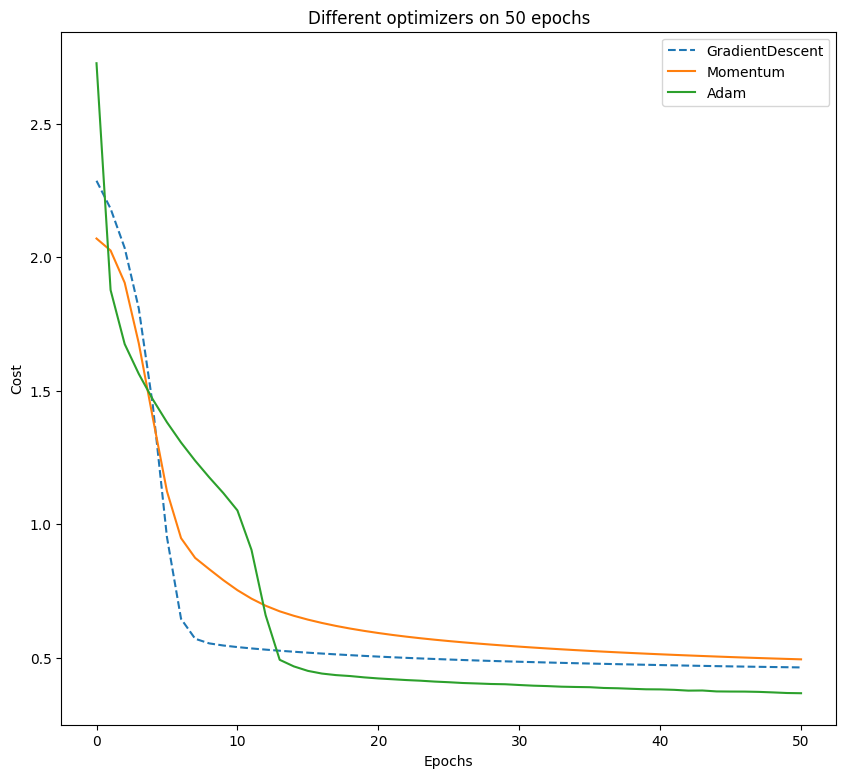

In [174]:

#Plotting the results

plt.figure(figsize=(10, 9))
plt.title("Different optimizers on {} epochs".format(total_epochs))
plt.plot(epochs, model1.history, "--",label="GradientDescent")
plt.plot(epochs, model2.history, label="Momentum")
plt.plot(epochs, model3.history, label="Adam")

plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()


As we can see, Adam is better since it converges faster than other algs.

Although, each of this algorithm will eventually lead us to minima, Adam will make it faster than others.